# Beta

Beta commonly refers to the stock's exposure to the whole market, such as S&P 500. The general form is a linear regression model.

In this notebook we will 

- Download the stock and the S&P 500 returns
- Use regression model to calculate the beta
- Use to the beta to hedge the exposure to S&P 500 (market)
- Calculate the vital statistics

First import libraries.

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt
from scipy import stats
plt.style.use('fivethirtyeight')

Get the data.

In [2]:
start = '2014-1-1'
end = '2015-1-1'

asset = pdr.get_data_yahoo('NFLX',start,end)['Adj Close'].pct_change()[1:]
market = pdr.get_data_yahoo('QQQ',start,end)['Adj Close'].pct_change()[1:]

Plot the daily returns

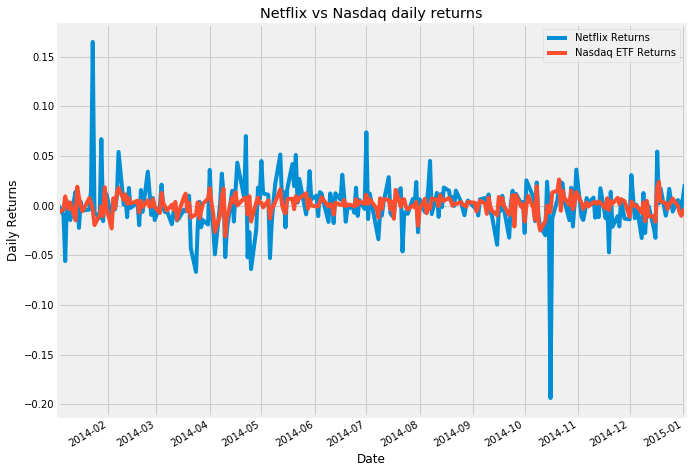

In [3]:
plt.figure(figsize=(10,8))
asset.plot(label = 'Netflix Returns')
market.plot(label = 'Nasdaq ETF Returns')
plt.ylabel('Daily Returns')
plt.title("Netflix vs Nasdaq daily returns")
plt.legend()


Use the regression model to find the alpha and beta. We will try 2 methods, to compare the results and then going forward we will use the shorter method.

Method 1

In [4]:
X = market.values # Get just the values, ignore the timestamps
Y = asset.values

def linreg(x,y):
    # We add a constant so that we can also fit an intercept (alpha) to the model
    # This just adds a column of 1s to our data
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    # Remove the constant now that we're done
    x = x[:, 1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print('alpha: ' + str(alpha))
print('beta: ' + str(beta))

alpha: -0.0007939099864934943
beta: 1.3227409515461646


Method 2

In [5]:
beta,alpha,_,_,_ = stats.linregress(market.values, asset.values)
print('alpha: ' + str(alpha))
print('beta: ' + str(beta))

alpha: -0.0007939099864934952
beta: 1.3227409515461652


We can see that using much simpler. We will use the scipy method going forward.

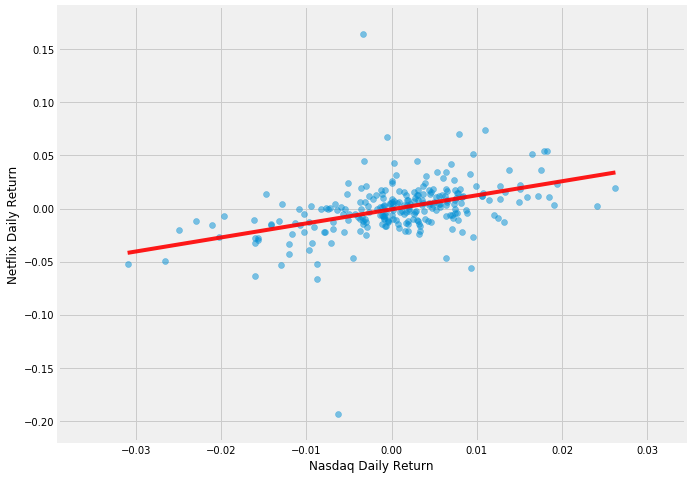

In [6]:
x2 = np.linspace(market.values.min(), market.values.max(), 100)
y_hat = alpha + beta * x2

plt.figure(figsize=(10,8))
plt.scatter(market.values, asset.values,alpha = 0.5)
plt.plot(x2,y_hat,'r',alpha = 0.9)
plt.xlabel("Nasdaq Daily Return")
plt.ylabel("Netflix Daily Return");

So from the above calculations we can see that for the selected time period, Netflix had a 1.32 beta exposure to Nasdaq etf. A high beta exposure, generally indicates higher than market returns when the overall market is rising and lower than market returns when the overall market is falling. Simply put, a high beta suggests that the asset has higher volatility than the market. <br>
We can reduce this asset's volatility by hedging the exposure to the market. We can do this by taking a short position on the Nasdaq Market. But such a strategy has its own problems. The calculated beta is not static and it will change dramatically as we include more data in our analysis.

Implementing the hedged portfolio.

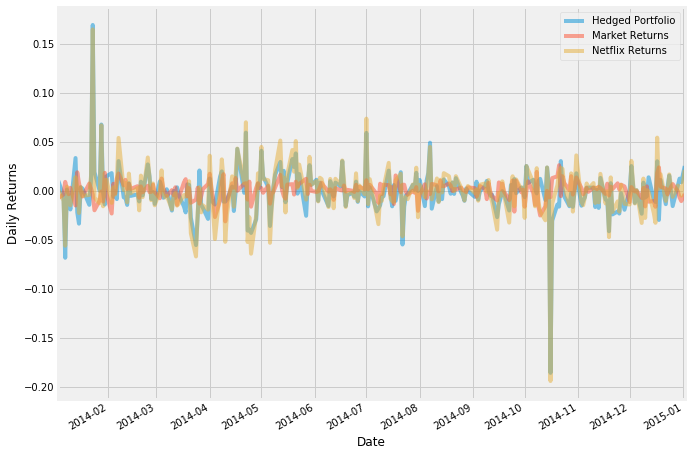

In [7]:
hedge_portfolio = -1 * beta * market + asset

plt.figure(figsize=(10,8))
hedge_portfolio.plot(alpha = 0.5, label = 'Hedged Portfolio')
market.plot(alpha = 0.5, label = "Market Returns")
asset.plot(alpha = 0.5, label = 'Netflix Returns')
plt.ylabel('Daily Returns')
plt.legend();

In the above calculation we assumed the beta stays steady(not realistic) and hedged daily(incur cost). 

In [8]:
hedge_portfolio_mean, netflix_mean = hedge_portfolio.mean(), asset.mean()
hedge_portfolio_std, netflix_std = hedge_portfolio.std(), asset.std()

print(f"Hedged Portfolio Mean:{hedge_portfolio_mean} & Netflix mean:{netflix_mean}")
print(f"Hedged Portfolio Std:{hedge_portfolio_std} & Netflix Std:{netflix_std}")

Hedged Portfolio Mean:-0.000793909986493495 & Netflix mean:0.00020297484624172567
Hedged Portfolio Std:0.023970547932769804 & Netflix Std:0.026588077145583783


We can see that our standard deviation (volatility) has decreased, but we have also lost the mean returns (not counting the other trading expenses). This is the tradeoff, one has to accept when hedging. Sacrifice returns in pursuit of lower volatility.

In [9]:
beta_hedged,alpha_hedged,_,_,_ = stats.linregress(market.values, hedge_portfolio.values)

print(f' Netflix beta : {beta}, Hedge Portfolio Beta : {beta_hedged}')
print(f' Netflix alpha : {alpha}, Hedged Portfolio alpha :{alpha_hedged}')


 Netflix beta : 1.3227409515461652, Hedge Portfolio Beta : -2.345239853357562e-16
 Netflix alpha : -0.0007939099864934952, Hedged Portfolio alpha :-0.0007939099864934948


So we have reduced our beta exposure to the market, and our overall alpha is the same as before.